In [42]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

In [2]:
%matplotlib inline

In [3]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [59]:
# Store results for comparison
metrics_results = []

industries = {
    'agro': ['CPF.BK', 'CBG.BK', 'OSP.BK', 'ITC.BK', 'BTG.BK'],
    'consump': ['AURA.BK', 'STGT.BK', 'BLC.BK', 'SNPS.BK', 'SABINA.BK'],
    'fincial': ['KBANK.BK', 'KTB.BK', 'SCB.BK', 'BBL.BK', 'TISCO.BK'],
    'indus': ['PTTGC.BK', 'SCGP.BK', 'IVL.BK', 'MCS.BK', 'TSTH.BK'],
    'propcon': ['SCC.BK', 'CPN.BK', 'WHA.BK', 'TOA.BK', 'AP.BK'],
    'resource': ['PTTEP.BK', 'BCP.BK', 'PTT.BK', 'TOP.BK', 'GPSC.BK'],
    'service': ['CPALL.BK', 'AOT.BK', 'BDMS.BK', 'HMPRO.BK', 'MINT.BK'],
    'tech': ['ADVANC.BK', 'TRUE.BK', 'DELTA.BK', 'CCET.BK', 'KCE.BK']
}

# Sequence creator
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, :])
        y.append(data[i, 0])  # Always predict 'Close'
    return np.array(X), np.array(y)

# Loop through all stocks
for industry, stocks in industries.items():
    for stock in stocks:
        print(f"\n🔍 Processing: {industry}/{stock}")

        model_file = os.path.join("models", industry, f"{stock}_model.keras")
        scaler_file = os.path.join("models", industry, f"{stock}_scaler.pkl")
        data_file = os.path.join("data", industry, f"{stock}.csv")

        if not (os.path.exists(model_file) and os.path.exists(scaler_file) and os.path.exists(data_file)):
            print(f"⚠️ Missing model, scaler, or data for {stock}. Skipping...")
            continue

        # Load model and scaler
        model = load_model(model_file)
        with open(scaler_file, 'rb') as f:
            scaler = pickle.load(f)

        # Load and prepare dataframe
        df = pd.read_csv(data_file)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # Automatically detect features used during training
        if scaler.n_features_in_ == 2:
            df = df[['Close', 'Volume']]
        else:
            df = df[['Close']]

        df = df.dropna()
        scaled_data = scaler.transform(df)

        # Split
        train_size = int(len(scaled_data) * 0.8)
        train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

        if len(test_data) < 61:
            print(f"⚠️ Not enough test data for {stock}. Skipping...")
            continue

        # Create sequences
        x_test, y_test = create_sequences(test_data)

        if len(x_test) == 0 or len(y_test) == 0:
            print(f"⚠️ No test sequences for {stock}. Skipping...")
            continue

        # Predict
        test_predictions = model.predict(x_test)

        # Rescale
        num_features = scaler.n_features_in_
        test_predictions_padded = np.concatenate(
            [test_predictions, np.zeros((len(test_predictions), num_features - 1))],
            axis=1
        )
        y_test_padded = np.concatenate(
            [y_test.reshape(-1, 1), np.zeros((len(y_test), num_features - 1))],
            axis=1
        )

        test_predictions_rescaled = scaler.inverse_transform(test_predictions_padded)[:, 0]
        y_test_rescaled = scaler.inverse_transform(y_test_padded)[:, 0]

        # Metrics
        mse = mean_squared_error(y_test_rescaled, test_predictions_rescaled)
        mae = mean_absolute_error(y_test_rescaled, test_predictions_rescaled)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test_rescaled - test_predictions_rescaled) / y_test_rescaled)) * 100

        print(f"📈 Evaluation for {stock}:")
        print(f"   MAE  : {mae:.4f}")
        print(f"   RMSE : {rmse:.4f}")
        print(f"   MAPE : {mape:.2f}%")

        # Store for final table
        metrics_results.append([industry, stock, mae, rmse, mape])

print("\n✅ All evaluations completed.")


🔍 Processing: agro/CPF.BK
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
📈 Evaluation for CPF.BK:
   MAE  : 0.3552
   RMSE : 0.4816
   MAPE : 1.53%

🔍 Processing: agro/CBG.BK
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
📈 Evaluation for CBG.BK:
   MAE  : 1.6809
   RMSE : 2.1908
   MAPE : 2.40%

🔍 Processing: agro/OSP.BK
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
📈 Evaluation for OSP.BK:
   MAE  : 0.6867
   RMSE : 0.9601
   MAPE : 3.73%

🔍 Processing: agro/ITC.BK
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step
📈 Evaluation for ITC.BK:
   MAE  : 0.5688
   RMSE : 0.7535
   MAPE : 3.62%

🔍 Processing: agro/BTG.BK
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
📈 Evaluation for BTG.BK:
   MAE  : 0.7175
   RMSE : 0.8587
   MAPE : 4.08%

🔍 Processing: consump/AURA.BK
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
📈 Evaluation for AURA.BK:
   MAE  : 0.4192
   RMSE : 0.5607
   MAPE : 2.72%

🔍 Processing: consump/STGT.BK
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
📈 Evaluation for STGT.BK:
   MAE  : 0.3987
   RMSE : 0.5485
   MAPE : 4.09%

🔍 Proc

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 28 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
📈 Evaluation for PTTGC.BK:
   MAE  : 0.9744
   RMSE : 1.2478
   MAPE : 4.35%

🔍 Processing: indus/SCGP.BK
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
📈 Evaluation for SCGP.BK:
   MAE  : 1.2133
   RMSE : 1.5290
   MAPE : 5.02%

🔍 Processing: indus/IVL.BK
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
📈 Evaluation for IVL.BK:
   MAE  : 0.7894
   RMSE : 1.0010
   MAPE : 3.77%

🔍 Processing: indus/MCS.BK
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
📈 Evaluation for MCS.BK:
   MAE  : 0.1620
   RMSE : 0.1974
   MAPE : 2.38%

🔍 Processing: indus/TSTH.BK
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
📈 Evaluation for TSTH.BK:
   MAE  : 0.0248
   RMSE : 0.0355
   MAPE : 4.05%

🔍 Processing: propcon/SCC.BK


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 28 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
📈 Evaluation for SCC.BK:
   MAE  : 8.3497
   RMSE : 10.1052
   MAPE : 4.68%

🔍 Processing: propcon/CPN.BK
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
📈 Evaluation for CPN.BK:
   MAE  : 1.0377
   RMSE : 1.4496
   MAPE : 1.89%

🔍 Processing: propcon/WHA.BK
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
📈 Evaluation for WHA.BK:
   MAE  : 0.1430
   RMSE : 0.1887
   MAPE : 2.98%

🔍 Processing: propcon/TOA.BK
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
📈 Evaluation for TOA.BK:
   MAE  : 1.3323
   RMSE : 1.4560
   MAPE : 8.88%

🔍 Processing: propcon/AP.BK
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
📈 Evaluation for AP.BK:
   MAE  : 0.2313
   RMSE : 0.3017
   MAPE : 2.69%

🔍 Processing: resource/PTTEP.BK
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
📈 Evaluation for PTTEP.BK:
   MAE  : 2.1375
   RMSE : 2.7366
   MAPE : 1.72%

🔍 Processing: resource/BCP.BK
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
📈 Evaluation for BCP.BK:
   MAE  : 0.8836
   RMSE : 1.0971
   MAPE : 2.60%

🔍 Processing: resource/

In [60]:
# Recreate and restyle the DataFrame after evaluation
metrics_df = pd.DataFrame(metrics_results, columns=['Industry', 'Stock', 'MAE', 'RMSE', 'MAPE'])
metrics_df.set_index(['Industry', 'Stock'], inplace=True)

def color_map(val):
    if val <= 5:
        return 'background-color: #90EE90'
    elif val <= 10:
        return 'background-color: #FFA500'
    else:
        return 'background-color: #FF0000'

styled_df = metrics_df.style.applymap(color_map)
styled_df

/var/folders/vw/288jn05573d78l0mr6f151zc0000gn/T/ipykernel_9527/3682517301.py:13: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = metrics_df.style.applymap(color_map)


In [56]:
metrics_results

[['agro',
  'CPF.BK',
  0.3552270343970578,
  0.4815581678578735,
  1.5336194633112301],
 ['agro', 'CBG.BK', 1.6808602074105141, 2.190779290433538, 2.402515340994144],
 ['agro',
  'OSP.BK',
  0.6866518163912159,
  0.9601219340996389,
  3.7253864682626996],
 ['agro',
  'ITC.BK',
  0.5688009133849377,
  0.7535363847292211,
  3.6155852090967846],
 ['agro', 'BTG.BK', 0.7174568655600523, 0.8587350042371157, 4.080994587466645],
 ['consump',
  'AURA.BK',
  0.4192443795789459,
  0.5606726975944231,
  2.724623408571521],
 ['consump',
  'STGT.BK',
  0.39870479823328664,
  0.5484794752652736,
  4.0922473872882765],
 ['consump',
  'BLC.BK',
  0.120160492223281,
  0.13287911209504055,
  2.8951653637841153],
 ['consump',
  'SABINA.BK',
  0.3235440341877478,
  0.42420637361512153,
  1.5595614679452496],
 ['fincial',
  'KBANK.BK',
  2.756789476513954,
  3.4696917062740993,
  1.8293521814776763],
 ['fincial',
  'KTB.BK',
  0.3996914194340436,
  0.5087026774835262,
  1.96081221843133],
 ['fincial',
  'S

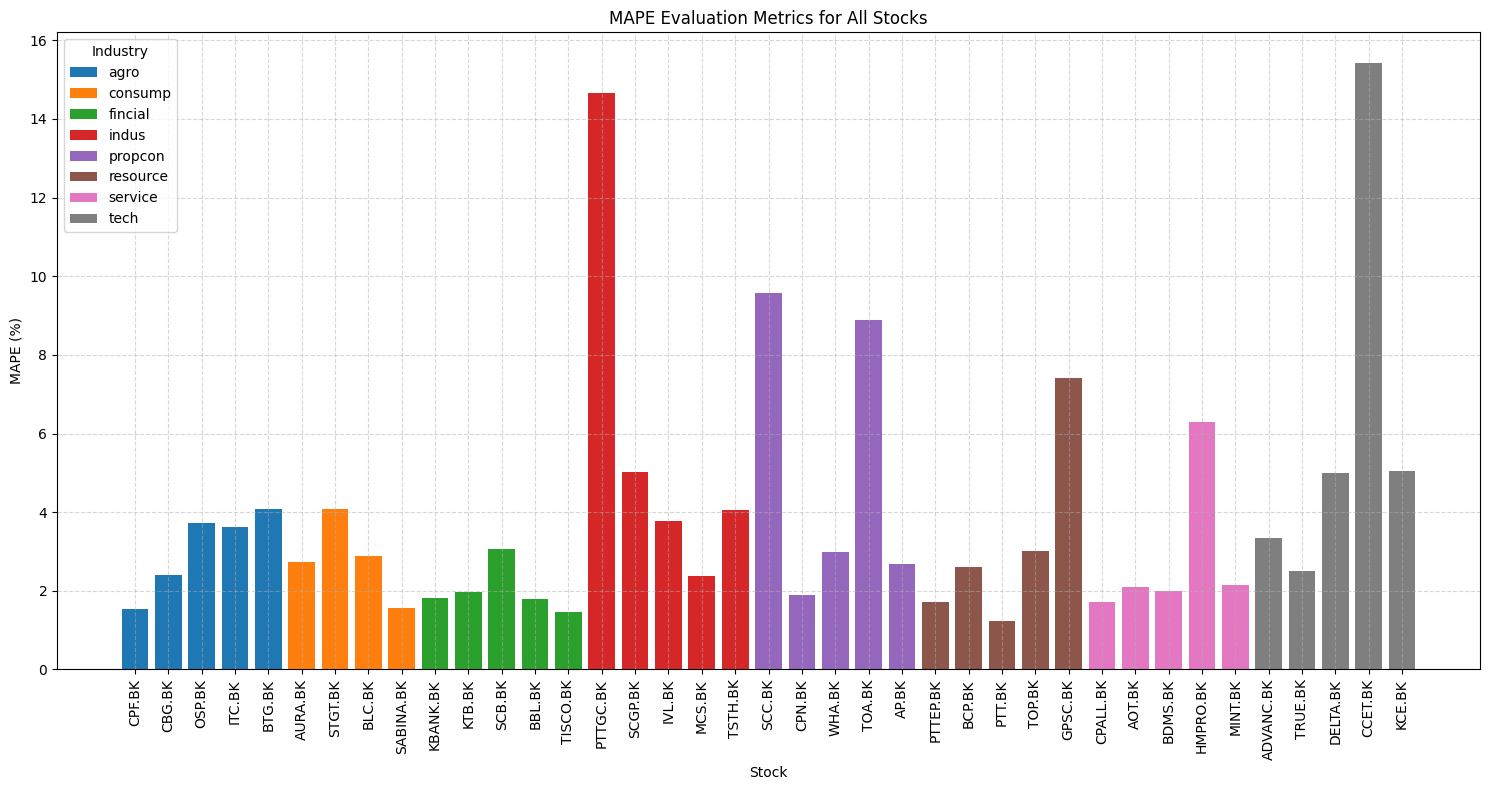

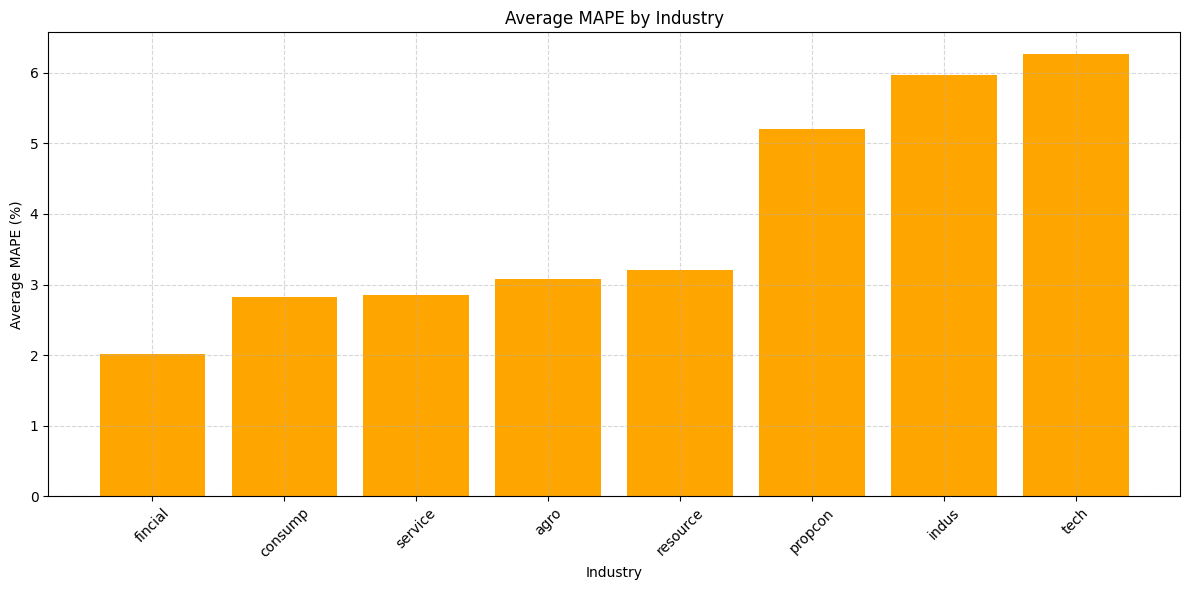

In [6]:
# Convert list to DataFrame
mape_df = pd.DataFrame(metrics_results, columns=['Industry', 'Stock', 'MAE', 'RMSE', 'MAPE'])

# Plot MAPE for each stock, grouped by industry
plt.figure(figsize=(15, 8))
for industry in mape_df['Industry'].unique():
    subset = mape_df[mape_df['Industry'] == industry]
    plt.bar(subset['Stock'], subset['MAPE'], label=industry)

plt.title('MAPE Evaluation Metrics for All Stocks')
plt.xlabel('Stock')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=90)
plt.legend(title='Industry')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Industry-wise MAPE Comparison
industry_avg_mape = mape_df.groupby('Industry')['MAPE'].mean().reset_index().sort_values(by='MAPE')

# Plot average MAPE per industry
plt.figure(figsize=(12, 6))
plt.bar(industry_avg_mape['Industry'], industry_avg_mape['MAPE'], color='orange')
plt.title('Average MAPE by Industry')
plt.xlabel('Industry')
plt.ylabel('Average MAPE (%)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# Run individual -------------------------------------------------------

In [19]:
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [30]:
industry = "indus"
stock = "PTTGC.BK"

In [16]:
# List of stocks to tune individually
stocks_to_tune = {
    'indus': ['PTTGC.BK'],
    'propcon': ['SCC.BK'],
    'resource': ['GPSC.BK'],
    'service': ['HMPRO.BK'],
    'tech': ['CCET.BK']
}

def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X).reshape(-1, sequence_length, 1), np.array(y)

def build_model(input_shape, lstm_units=50, dense_units=25, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=dense_units))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def run_tuner(x_train, y_train, input_shape, project_name):
    def model_builder(hp):
        return build_model(
            input_shape=input_shape,
            lstm_units=hp.Choice('lstm_units', [32, 64, 100, 128]),
            dropout_rate=hp.Choice('dropout_rate', [0.1, 0.2, 0.3]),
            dense_units=hp.Choice('dense_units', [16, 25, 50])
        )

    tuner = kt.RandomSearch(
        model_builder,
        objective='val_loss',
        max_trials=3,
        executions_per_trial=1,
        directory='tuning_logs',
        project_name=project_name
    )

    tuner.search(x_train, y_train, validation_split=0.2, epochs=30,
                 batch_size=32, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

    best_model = tuner.get_best_models(1)[0]
    best_hp = tuner.get_best_hyperparameters(1)[0]
    return best_model, best_hp

In [17]:
stock_configs = {}

for industry, stock_list in stocks_to_tune.items():
    for stock in stock_list:
        print(f"\n🎯 Tuning model for {industry}/{stock}...")

        data_path = os.path.join("data", industry, f"{stock}.csv")
        df = pd.read_csv(data_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        df = df[['Close']]

        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df)
        train_data, _ = train_test_split(scaled_data, train_size=0.8, shuffle=False)
        x_train, y_train = create_sequences(train_data)

        best_model, best_hp = run_tuner(
            x_train, y_train,
            input_shape=(x_train.shape[1], 1),
            project_name=f"{industry}_{stock}_tuning"
        )

        stock_configs[stock] = {
            'lstm_units': best_hp.get('lstm_units'),
            'dropout_rate': best_hp.get('dropout_rate'),
            'dense_units': best_hp.get('dense_units')
        }

        print(f"✅ Best config for {stock}: {stock_configs[stock]}")

Trial 3 Complete [00h 01m 11s]
val_loss: 0.00017586915055289865

Best val_loss So Far: 0.00017586915055289865
Total elapsed time: 00h 02m 44s
✅ Best config for CCET.BK: {'lstm_units': 100, 'dropout_rate': 0.3, 'dense_units': 50}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [20]:
for industry, stocks in stocks_to_tune.items():
    for stock in stocks:
        print(f"\n📦 Training model for {stock} using individual config")

        data_file = os.path.join("data", industry, f"{stock}.csv")
        if not os.path.exists(data_file):
            print(f"⚠️ File not found: {data_file}")
            continue

        df = pd.read_csv(data_file)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        df = df[['Close']]

        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df)
        train_data, test_data = train_test_split(scaled_data, train_size=0.8, shuffle=False)

        if len(test_data) < 60:
            print(f"⚠️ Not enough test data for {stock}. Skipping...")
            continue

        x_train, y_train = create_sequences(train_data)
        x_test, y_test = create_sequences(test_data)

        if len(x_train) == 0 or len(x_test) == 0:
            print(f"⚠️ No sequences generated for {stock}. Skipping...")
            continue

        # Use the stock-specific config
        if 'stock_configs' in globals() and stock in stock_configs:
            config = stock_configs[stock]
        else:
            print(f"⚠️ No config found for {stock}. Skipping...")
            continue

        model = build_model(
            input_shape=(x_train.shape[1], 1),
            lstm_units=config['lstm_units'],
            dropout_rate=config['dropout_rate'],
            dense_units=config['dense_units']
        )

        model_dir = os.path.join("models", industry)
        os.makedirs(model_dir, exist_ok=True)
        model_file = os.path.join(model_dir, f"{stock}_model.keras")
        scaler_file = os.path.join(model_dir, f"{stock}_scaler.pkl")

        early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(model_file, monitor='loss', save_best_only=True)

        model.fit(
            x_train, y_train,
            batch_size=32,
            epochs=50,
            validation_split=0.2,
            callbacks=[early_stop, model_checkpoint]
        )

        model.save(model_file)
        with open(scaler_file, 'wb') as f:
            pickle.dump(scaler, f)
        print(f"✅ Model and scaler saved for {stock}")

print("\n✅ Selected models retrained and saved!")


📦 Training model for PTTGC.BK using individual config
Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.1349 - val_loss: 0.0032
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0066 - val_loss: 0.0046
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 0.0053 - val_loss: 0.0024
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0033 - val_loss: 9.1780e-04
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0032 - val_loss: 8.0697e-04
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 0.0912 - val_loss: 0.0129
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - loss: 0.1215 - val_loss: 0.0054
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0081 - val_loss: 0.0129
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0068 - val_loss: 0.0118
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 0.0055 - val_loss: 0.0090
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - loss: 0.0051 - val_loss: 0.0103
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.0051 - val_loss: 0.0082
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.0040 - val_loss: 0.0065
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 0.1721 - val_loss: 0.0044
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0080 - val_loss: 0.0126
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0060 - val_loss: 0.0105
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.0048 - val_loss: 0.0056
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0041 - val_loss: 0.0057
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.0034 - val_loss: 5.8308e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 3.6071e-04 - val_loss: 5.0126e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 2.4667e-04 - val_loss: 4.1428e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 2.3754e-04 - val_loss: 3.8688e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 2.0865e-04 - val_loss: 3.6732e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 2.1877e-04 - val_loss: 3.3565e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 1.8857e-04 - val_loss: 3.2389e-04
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 1.8213e-04 - val_loss: 3.0488e-04
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 2.0582e-04 - val_loss: 3.3917e-04
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 1.9993e-04 - val_loss: 2.8487e-04
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 1.8884e-04 - val_los

In [27]:
# Take the last 60 days from the dataset for generating future predictions
last_60_days = scaled_data[-60:]

# Reshape last_60_days to fit the model input shape
x_future = last_60_days.reshape((1, last_60_days.shape[0], 1))

# Generate predictions
predictions = []
for _ in range(30):
    pred = model.predict(x_future) # Predict the next day
    predictions.append(pred[0,0]) # Append the prediction to the list

    # Update x_future by removing the first value and appending the prediction at the end
    x_future = np.append(x_future[:, 1:, :], np.array([[pred[0, 0]]]).reshape(1, 1, 1), axis=1)

# Inverse transform the predictions to get them back to the original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Convert predictions to a DataFrame
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)
predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Predicted Close'])
print(predictions_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

In [25]:
data_path = os.path.join("data", "propcon", "SCC.BK.csv")
df = pd.read_csv(data_path)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['Close']]
df

,Close
Date,
2020-01-02,333.359375
2020-01-03,327.406586
2020-01-06,316.351288
2020-01-07,321.453674
2020-01-08,310.398376
...,...
2025-03-26,156.000000
2025-03-27,158.000000
2025-03-28,153.500000


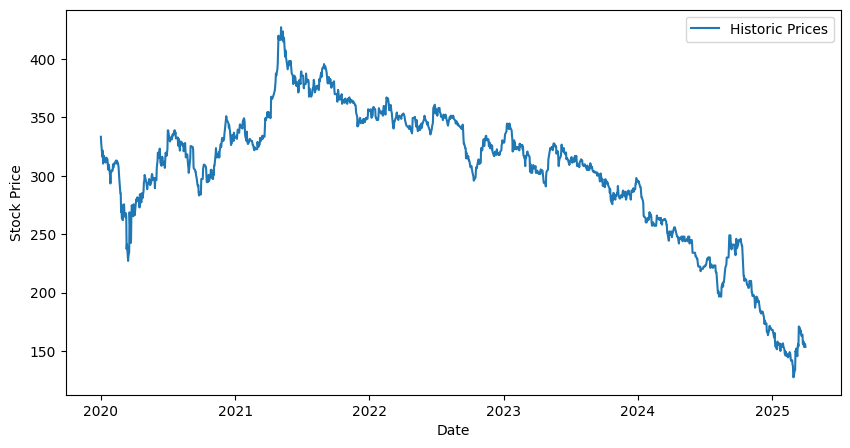

In [30]:
plt.figure(figsize=(10,5))
plt.plot(df['Close'], label='Historic Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

/var/folders/vw/288jn05573d78l0mr6f151zc0000gn/T/ipykernel_9527/2709280117.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


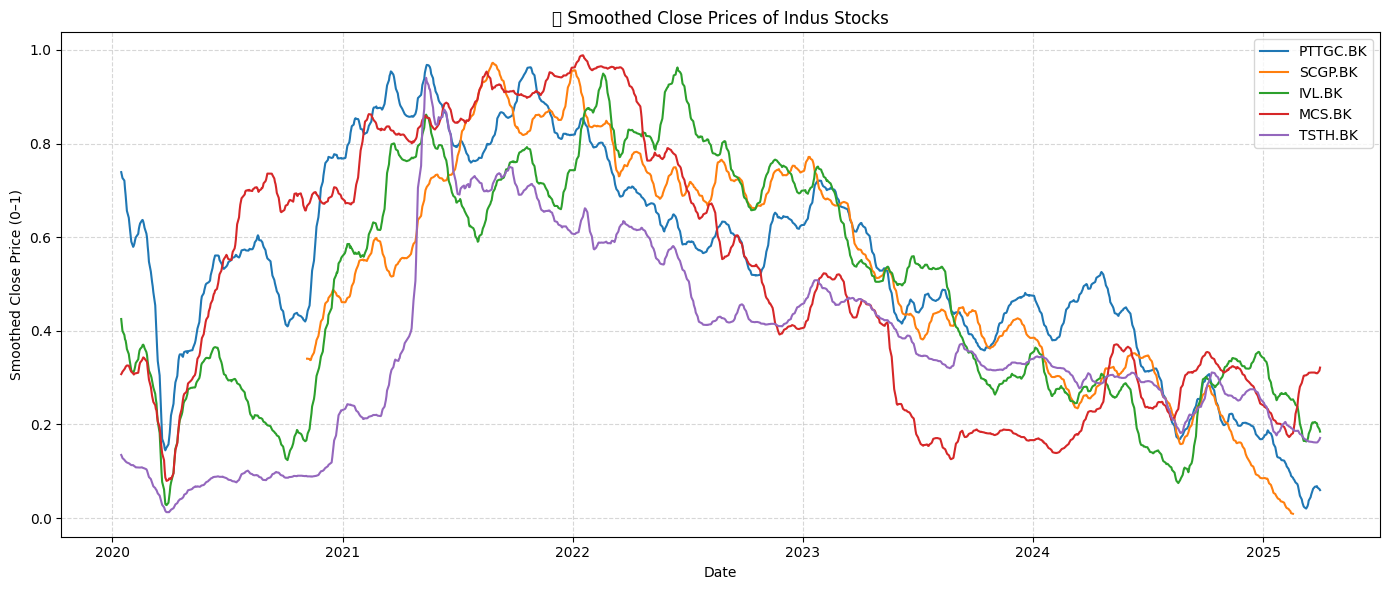

In [41]:
propcon_stocks = ['PTTGC.BK', 'SCGP.BK', 'IVL.BK', 'MCS.BK', 'TSTH.BK']
industry = 'indus'

# Set up plot
plt.figure(figsize=(14, 6))

for stock in propcon_stocks:
    file_path = os.path.join("data", industry, f"{stock}.csv")
    
    if not os.path.exists(file_path):
        print(f"⚠️ Missing file for {stock}, skipping.")
        continue

    # Load and scale data
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df[['Close']]

    scaler = MinMaxScaler()
    df['Scaled Close'] = scaler.fit_transform(df[['Close']])
    df['Smoothed Close'] = df['Scaled Close'].rolling(window=10).mean()

    # Plot
    plt.plot(df.index, df['Smoothed Close'], label=stock)

# Customize plot
plt.title("📊 Smoothed Close Prices of Indus Stocks")
plt.xlabel("Date")
plt.ylabel("Smoothed Close Price (0–1)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/var/folders/vw/288jn05573d78l0mr6f151zc0000gn/T/ipykernel_9527/877440861.py:32: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


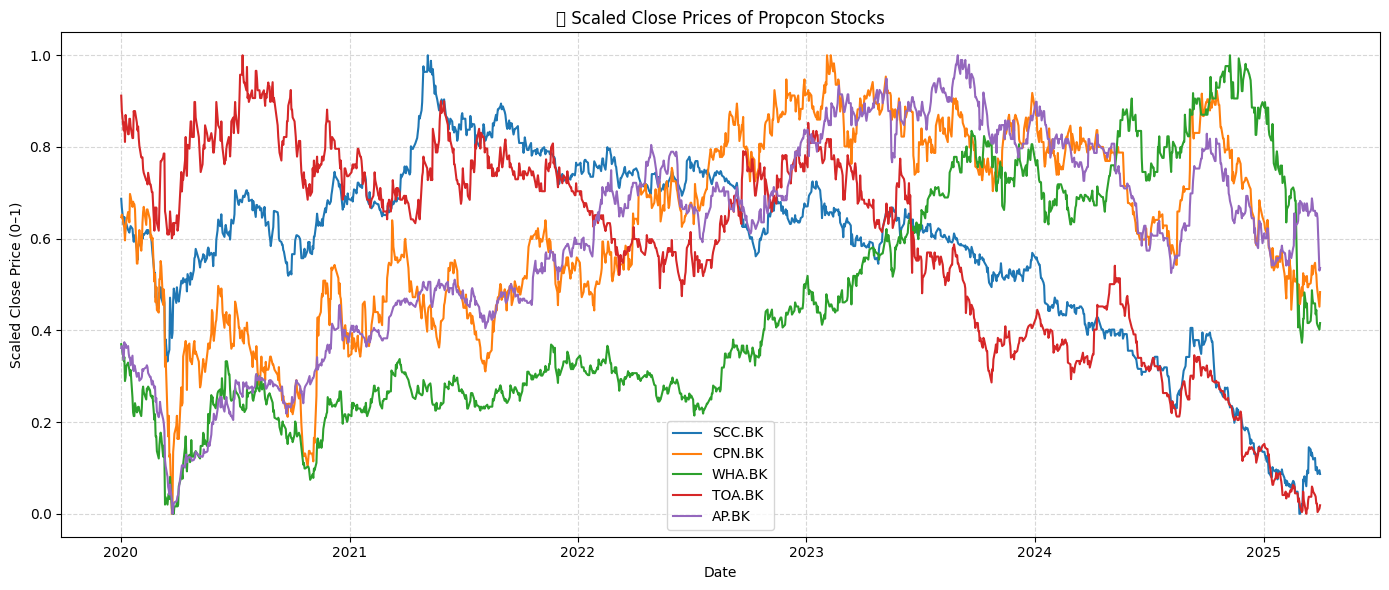

In [31]:
propcon_stocks = ['SCC.BK', 'CPN.BK', 'WHA.BK', 'TOA.BK', 'AP.BK']
industry = 'propcon'

# Set up plot
plt.figure(figsize=(14, 6))

for stock in propcon_stocks:
    file_path = os.path.join("data", industry, f"{stock}.csv")
    
    if not os.path.exists(file_path):
        print(f"⚠️ Missing file for {stock}, skipping.")
        continue

    # Load and scale data
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df[['Close']]

    scaler = MinMaxScaler()
    df['Scaled Close'] = scaler.fit_transform(df[['Close']])

    # Plot
    plt.plot(df.index, df['Scaled Close'], label=stock)

# Customize plot
plt.title("📊 Scaled Close Prices of Propcon Stocks")
plt.xlabel("Date")
plt.ylabel("Scaled Close Price (0–1)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/var/folders/vw/288jn05573d78l0mr6f151zc0000gn/T/ipykernel_9527/3454768290.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


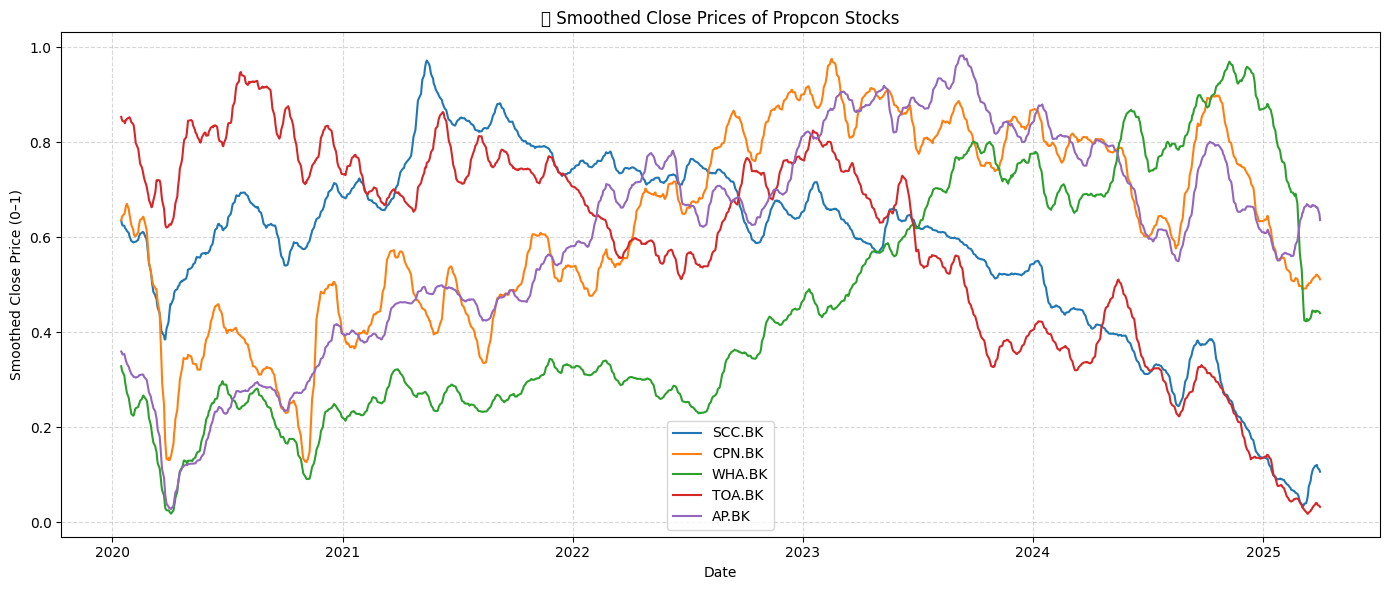

In [33]:
propcon_stocks = ['SCC.BK', 'CPN.BK', 'WHA.BK', 'TOA.BK', 'AP.BK']
industry = 'propcon'

# Set up plot
plt.figure(figsize=(14, 6))

for stock in propcon_stocks:
    file_path = os.path.join("data", industry, f"{stock}.csv")
    
    if not os.path.exists(file_path):
        print(f"⚠️ Missing file for {stock}, skipping.")
        continue

    # Load and scale data
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df[['Close']]

    scaler = MinMaxScaler()
    df['Scaled Close'] = scaler.fit_transform(df[['Close']])
    df['Smoothed Close'] = df['Scaled Close'].rolling(window=10).mean()

    # Plot
    plt.plot(df.index, df['Smoothed Close'], label=stock)

# Customize plot
plt.title("📊 Smoothed Close Prices of Propcon Stocks")
plt.xlabel("Date")
plt.ylabel("Smoothed Close Price (0–1)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/var/folders/vw/288jn05573d78l0mr6f151zc0000gn/T/ipykernel_9527/2098930940.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


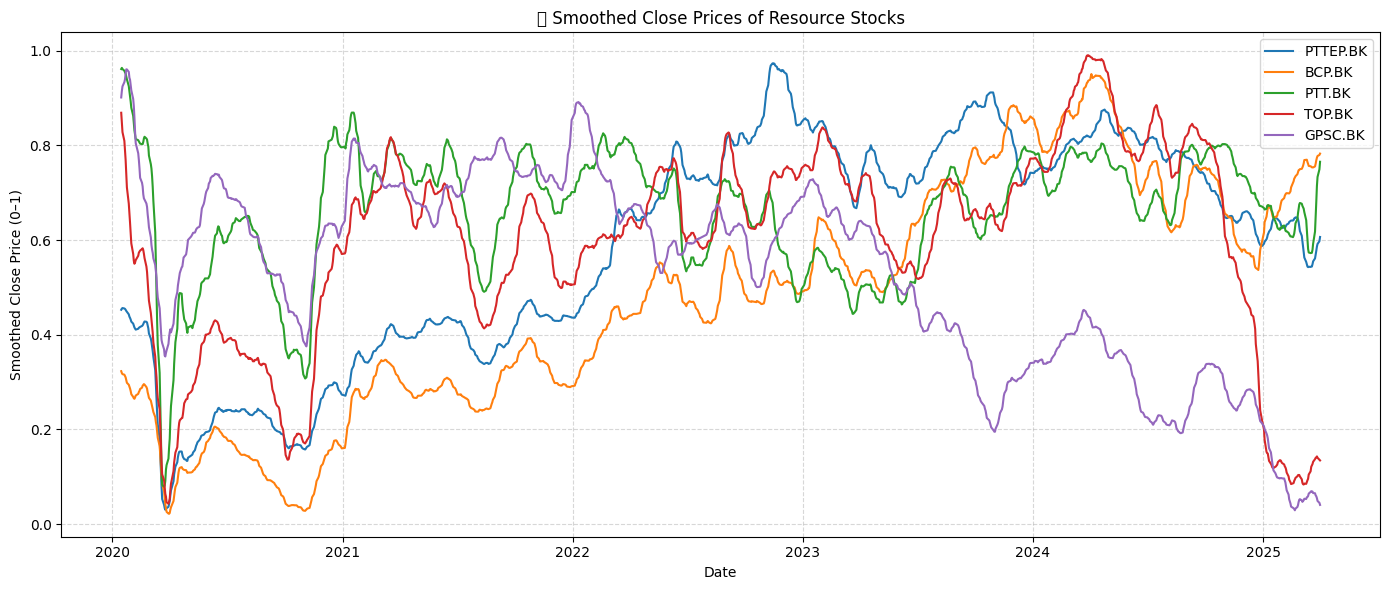

In [35]:
propcon_stocks = ['PTTEP.BK', 'BCP.BK', 'PTT.BK', 'TOP.BK', 'GPSC.BK']
industry = 'resource'

# Set up plot
plt.figure(figsize=(14, 6))

for stock in propcon_stocks:
    file_path = os.path.join("data", industry, f"{stock}.csv")
    
    if not os.path.exists(file_path):
        print(f"⚠️ Missing file for {stock}, skipping.")
        continue

    # Load and scale data
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df[['Close']]

    scaler = MinMaxScaler()
    df['Scaled Close'] = scaler.fit_transform(df[['Close']])
    df['Smoothed Close'] = df['Scaled Close'].rolling(window=10).mean()

    # Plot
    plt.plot(df.index, df['Smoothed Close'], label=stock)

# Customize plot
plt.title("📊 Smoothed Close Prices of Resource Stocks")
plt.xlabel("Date")
plt.ylabel("Smoothed Close Price (0–1)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/var/folders/vw/288jn05573d78l0mr6f151zc0000gn/T/ipykernel_9527/344165664.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


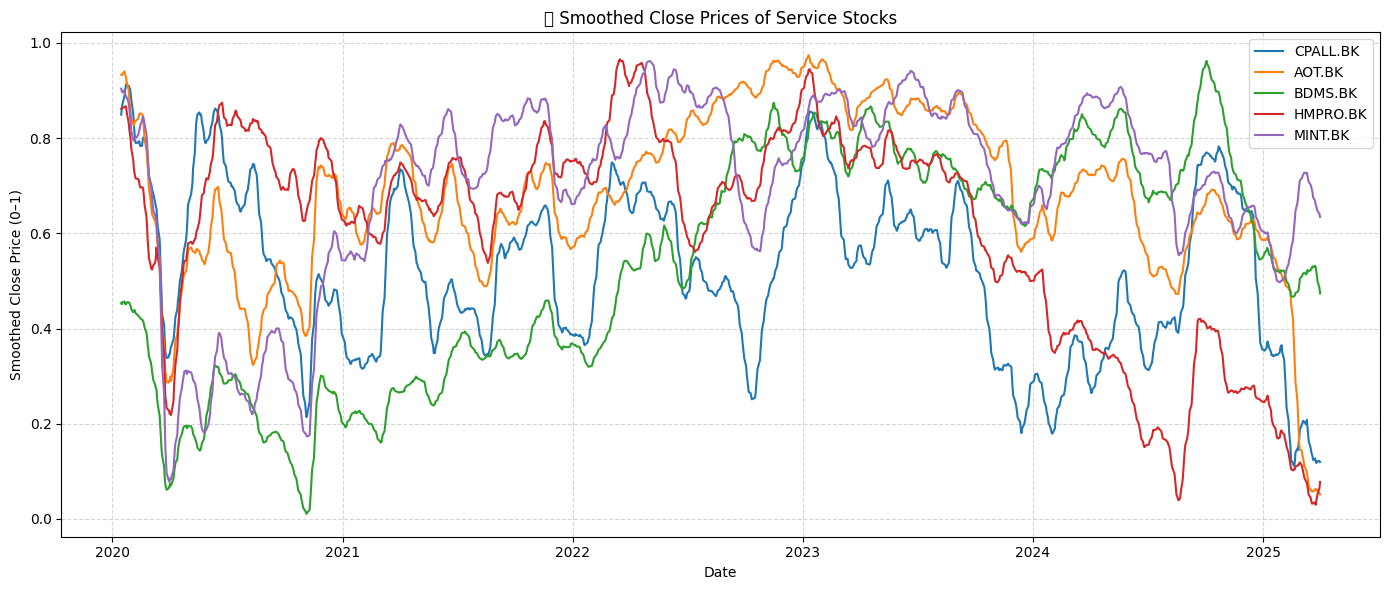

In [38]:
propcon_stocks = ['CPALL.BK', 'AOT.BK', 'BDMS.BK', 'HMPRO.BK', 'MINT.BK']
industry = 'service'

# Set up plot
plt.figure(figsize=(14, 6))

for stock in propcon_stocks:
    file_path = os.path.join("data", industry, f"{stock}.csv")
    
    if not os.path.exists(file_path):
        print(f"⚠️ Missing file for {stock}, skipping.")
        continue

    # Load and scale data
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df[['Close']]

    scaler = MinMaxScaler()
    df['Scaled Close'] = scaler.fit_transform(df[['Close']])
    df['Smoothed Close'] = df['Scaled Close'].rolling(window=10).mean()

    # Plot
    plt.plot(df.index, df['Smoothed Close'], label=stock)

# Customize plot
plt.title("📊 Smoothed Close Prices of Service Stocks")
plt.xlabel("Date")
plt.ylabel("Smoothed Close Price (0–1)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/var/folders/vw/288jn05573d78l0mr6f151zc0000gn/T/ipykernel_9527/3970130530.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


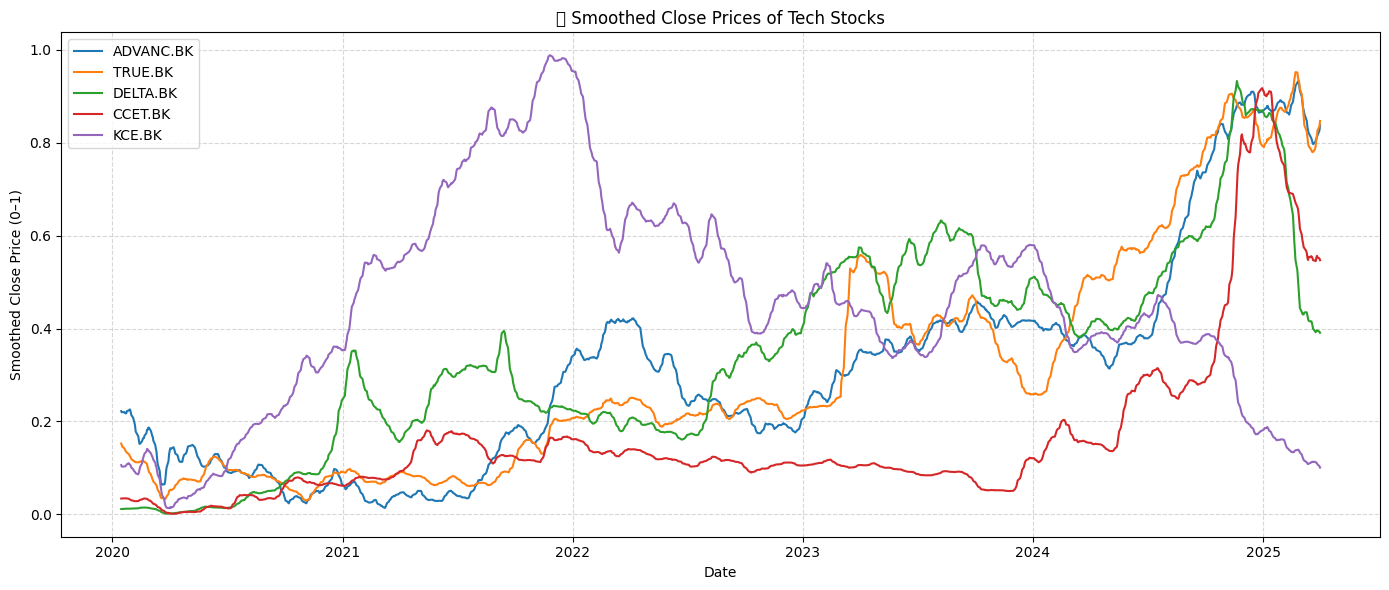

In [36]:
propcon_stocks = ['ADVANC.BK', 'TRUE.BK', 'DELTA.BK', 'CCET.BK', 'KCE.BK']
industry = 'tech'

# Set up plot
plt.figure(figsize=(14, 6))

for stock in propcon_stocks:
    file_path = os.path.join("data", industry, f"{stock}.csv")
    
    if not os.path.exists(file_path):
        print(f"⚠️ Missing file for {stock}, skipping.")
        continue

    # Load and scale data
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df[['Close']]

    scaler = MinMaxScaler()
    df['Scaled Close'] = scaler.fit_transform(df[['Close']])
    df['Smoothed Close'] = df['Scaled Close'].rolling(window=10).mean()

    # Plot
    plt.plot(df.index, df['Smoothed Close'], label=stock)

# Customize plot
plt.title("📊 Smoothed Close Prices of Tech Stocks")
plt.xlabel("Date")
plt.ylabel("Smoothed Close Price (0–1)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

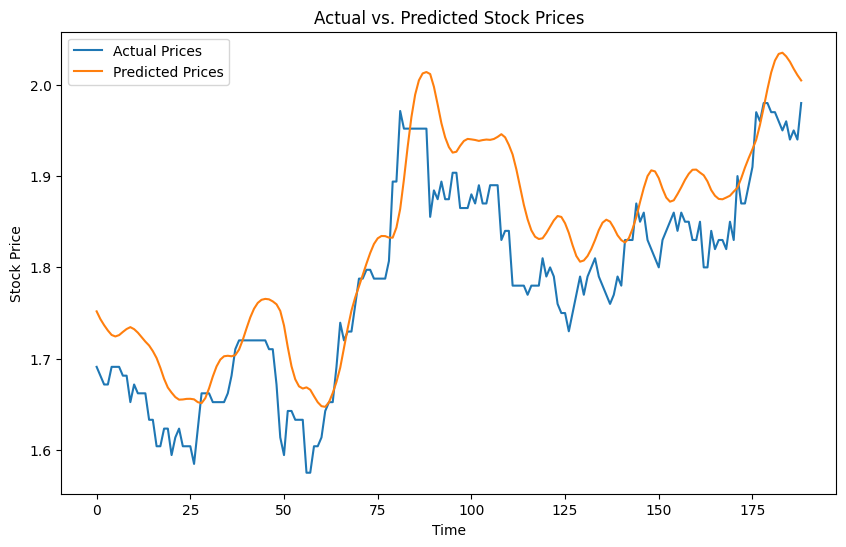

In [29]:
# Plot the actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Prices')
plt.plot(test_predictions, label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()